In [1]:
from pandas import read_excel
import numpy as np
from numpy import concatenate
from datetime import datetime
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error

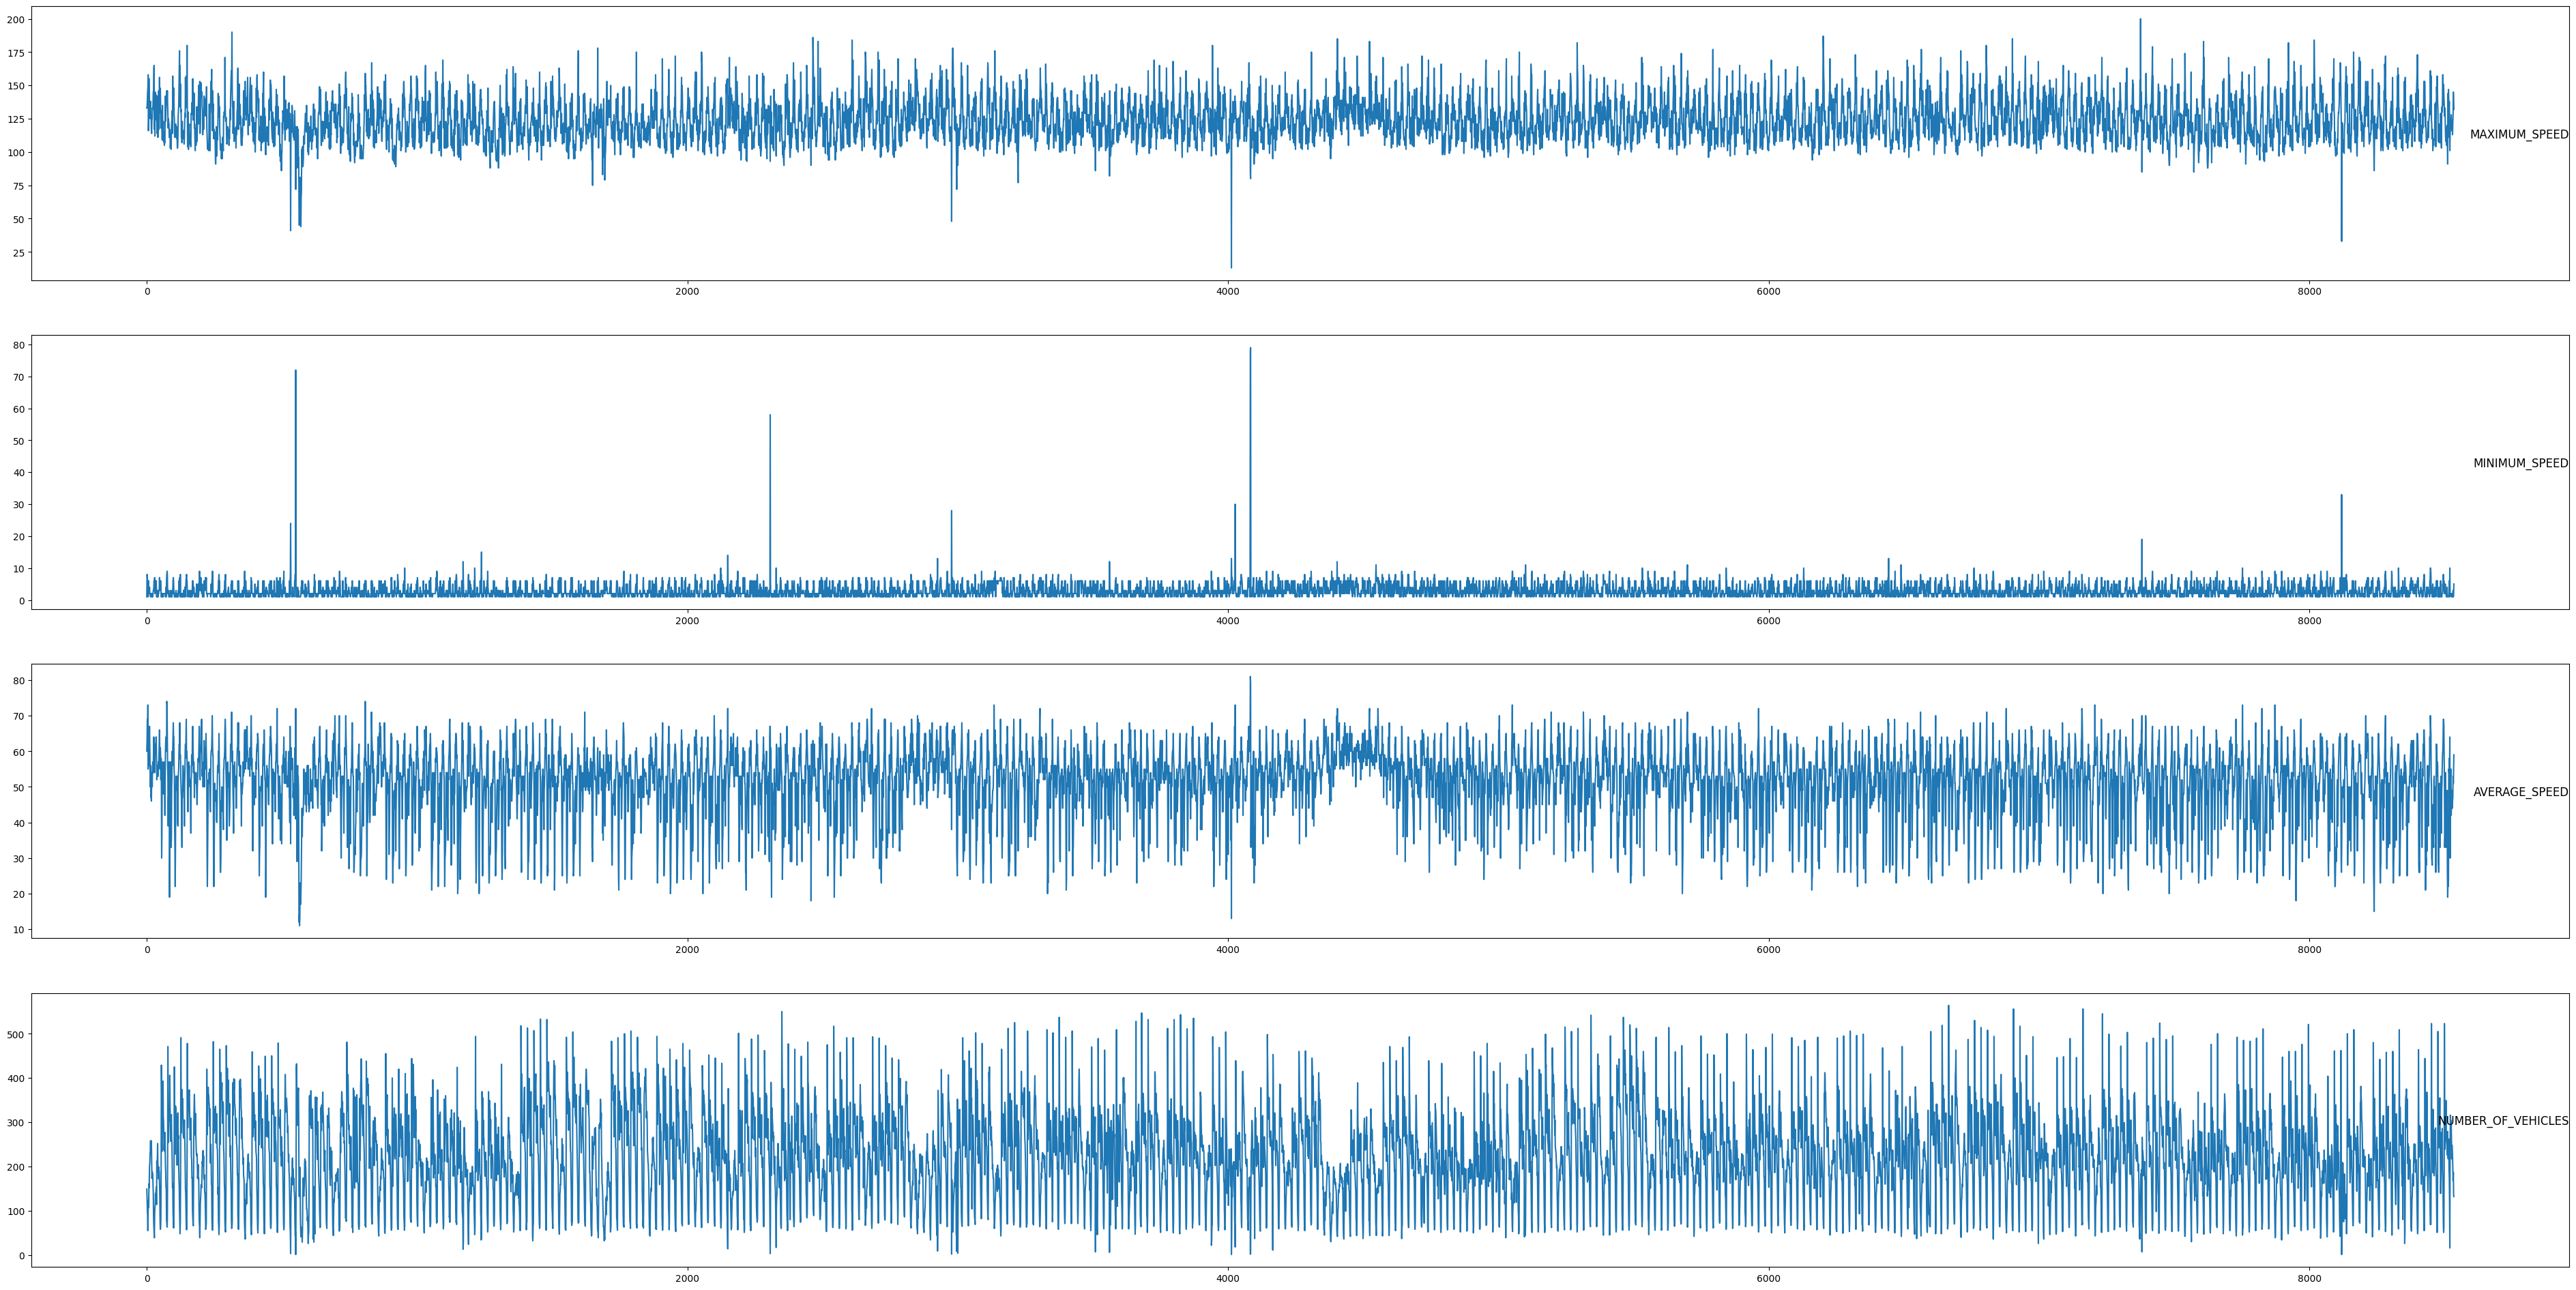

In [2]:
# load dataset
dataset = read_excel(r'C:\sxk990.xlsx', header=0, index_col=0)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure(figsize=(48, 24))
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
                agg.dropna(inplace=True)
        return agg

In [4]:
# specify the number of lag hours
n_hours = 6
n_steps = 3
n_features = 4
n_obs = n_hours * n_features
n_x = (n_hours * n_features) - n_steps
# frame as supervised learning
reframed = series_to_supervised(values, n_hours, n_steps)
# drop columns we don't want to predict

for i in range (0,n_steps):
   reframed.drop(reframed.columns[[n_obs+i,n_obs+i+1,n_obs+i+3]], axis=1, inplace=True) 

reframed

var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var1(t-5)  var2(t-5)  \
6         133.0        1.0       60.0      149.0      133.0        8.0   
7         133.0        8.0       63.0      130.0      139.0        7.0   
8         139.0        7.0       69.0      101.0      145.0        3.0   
9         145.0        3.0       61.0       90.0      148.0        6.0   
10        148.0        6.0       73.0       55.0      158.0        1.0   
...         ...        ...        ...        ...        ...        ...   
8528      118.0        2.0       53.0      291.0      122.0        2.0   
8529      122.0        2.0       55.0      302.0      128.0        2.0   
8530      128.0        2.0       42.0      304.0      124.0        2.0   
8531      124.0        2.0       45.0      263.0      121.0        1.0   
8532      121.0        1.0       49.0      217.0      116.0        1.0   

      var3(t-5)  var4(t-5)  var1(t-4)  var2(t-4)  ...  var2(t-2)  var3(t-2)  \
6          63.0      130.0      139.0        7.0  ...        6.0       73.0   
7          69.0      101.0      145.0        3.0  ...        1.0       55.0   
8          61.0       90.0      148.0        6.0  ...        6.0       60.0   
9          73.0       55.0      158.0        1.0  ...        3.0       56.0   
10         55.0      105.0      116.0        6.0  ...        2.0       58.0   
...         ...        ...        ...        ...  ...        ...        ...   
8528       55.0      302.0      128.0        2.0  ...        1.0       49.0   
8529       42.0      304.0      124.0        2.0  ...        1.0       49.0   
8530       45.0      263.0      121.0        1.0  ...        2.0       44.0   
8531       49.0      217.0      116.0        1.0  ...        1.0       46.0   
8532       49.0      248.0      124.0        2.0  ...        1.0       47.0   

      var4(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var3(t)  \
6          55.0      158.0        1.0       55.0      105.0     60.0   
7         105.0      116.0        6.0       60.0      124.0     56.0   
8         124.0      124.0        3.0       56.0      107.0     58.0   
9         107.0      155.0        2.0       58.0      161.0     62.0   
10        161.0      142.0        2.0       62.0      152.0     67.0   
...         ...        ...        ...        ...        ...      ...   
8528      217.0      116.0        1.0       49.0      248.0     44.0   
8529      248.0      124.0        2.0       44.0      235.0     46.0   
8530      235.0      113.0        1.0       46.0      224.0     47.0   
8531      224.0      122.0        1.0       47.0      198.0     53.0   
8532      198.0      128.0        3.0       53.0      168.0     51.0   

      var3(t+1)  var3(t+2)  
6          56.0       58.0  
7          58.0       62.0  
8          62.0       67.0  
9          67.0       62.0  
10         62.0       56.0  
...         ...        ...  
8528       46.0       47.0  
8529       47.0       53.0  
8530       53.0       51.0  
8531       51.0       55.0  
8532       55.0       59.0  

[8527 rows x 27 columns]

In [5]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [6]:
# split into train and test sets
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train = reframed[:int(len(reframed)*TRAIN_SIZE), :]
test = reframed[int(len(reframed)*TRAIN_SIZE):, :]

# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_steps:]
test_X, test_y = test[:, :n_obs], test[:, -n_steps:]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, len(test_X))

(5116, 24) (5116, 3) (3411, 24) (3411, 3) 3411


In [7]:
def sigmoid_act(x, der=False):
   import numpy as np

   if (der == True):  # Turev sigmoid
      f = 1 / (1 + np.exp(- 0.25*x)) * (1 - 1 / (1 + np.exp(- 0.25*x)))
   else:  # sigmoid
      f = 1 / (1 + np.exp(- 0.25*x))

   return f


def tanh_act(x, der=False):
   import numpy as np

   if (der == True):  # Turev tanh
      f = 1 - np.square(((np.exp(x)) - (np.exp(-x))) / ((np.exp(x)) + (np.exp(-x))))
   else:
      f = ((np.exp(x)) - (np.exp(-x))) / ((np.exp(x)) + (np.exp(-x)))

   return f

def Lineer_act(x, der=False):
   import numpy as np

   if (der == True):  # the derivative of the ReLU is the Heaviside Theta
      f = 1
   else:
      f = x

   return f



In [8]:

p = 30  # 1.Gizli Katman neron sayisi
q = 40  # 2.Gizli Katman neron sayisi
r = 30  # 3.Gizli Katman neron sayisi
s = n_steps

eta = 1/300            # Learning rate
alpha = 1 / 900      # Momentum

w10 = np.zeros((p, np.size(train_X, 1)))              # (k-1) 1. Katman Agirlik Degerleri - momentum icin.
w11 = 0.25 * np.random.randn(p, np.size(train_X, 1))   # 1. Katman
b1 = 0.25 * np.random.randn(p)

w20 = np.zeros((q, p))                          # (k-1) 2. Katman Agirlik Degerleri - momentum icin.
w21 = 0.25 * np.random.rand(q, p)                # 2. Katman
b2 = 0.25 * np.random.rand(q)

w30 = np.zeros((r, q))                          # (k-1) 3. Katman Agirlik Degerleri - momentum icin.
w31 = 0.25 * np.random.rand(r, q)                # 3. Katman
b3 = 0.25 * np.random.rand(r)


wOut0 = np.zeros((s, r))                        # (k-1) Cikis Katmani Agirlik Degerleri - momentum icin.
wOut1 = 0.25 * np.random.rand(s, r)              # Cikis Katmani
bOut = 0.25 * np.random.rand(s)

act = tanh_act

E_ani_max = []
E_ort = []
epoch = 1000                             # Iterasyon Sayisi


l= 999


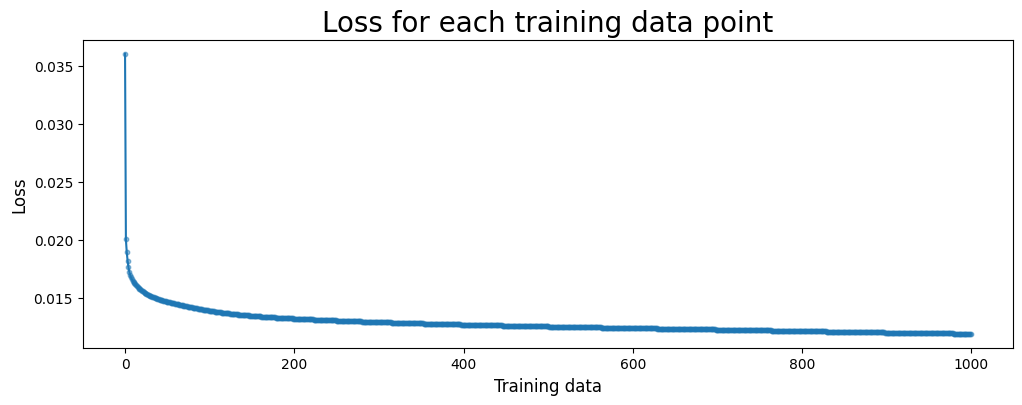

In [9]:
for l in range(epoch):
  E_ani = []
 
  for k in range(np.size(train_X, 0)):

    # 1: Egitim Veri Seti Girisi
    x = train_X[k]
   
    # 2: Feed forward
    w1 = w11
    v1 = np.dot(w1, x) + b1
    yl1 = act(v1)  # 1. Katman Cikisi   y1: Gercek cikis olduğundan farklı olsun diye yl1 yazildi.
    w2 = w21
    v2 = np.dot(w2, yl1) + b2
    yl2 = act(v2)  # 2. Katman Cikisi   y2: Gercek cikis olduğundan farklı olsun diye yl2 yazildi.
    w3 = w31
    v3 = np.dot(w3, yl2) + b3
    yl3 = act(v3)  # 3. Katman Cikisi

    wOut = wOut1
    v_o = np.dot(wOut, yl3) + bOut
    y = Lineer_act(v_o)  # Cikis Katmani Cikisi


    # 2.2: Cikis Katmani Yerel Gradyen
    delta_Out = (train_y[k] - y) * Lineer_act(v_o, der=True)
    

    # 2.3: Backpropagate
    
    delta_3 = np.dot(delta_Out, wOut) * act(v3, der=True)       # 3. Katman Yerel Gradyen
    delta_2 = np.dot(delta_3, w3) * act(v2, der=True)       # 2. Katman Yerel Gradyen
    delta_1 = np.dot(delta_2, w2) * act(v1, der=True)       # 1. Katman Yerel Gradyen

    # 3: Gradient descent
    
    wOut = wOut1 + eta * np.outer(delta_Out, yl3) + alpha * (wOut1 - wOut0)  # Cikis Katmani Agirlik güncelleme
    wOut0 = wOut1
    wOut1 = wOut
    bOut = bOut + eta * delta_Out    
 
    
    w3 = w31 + eta * np.outer(delta_3, yl2) + alpha * (w31 - w30)  # Gizli Katman 3 Agirlik güncelleme
    w30 = w31
    w31 = w3
    b3 = b3 + eta * delta_3


    w2 = w21 + eta * np.outer(delta_2, yl1) + alpha * (w21 - w20)  # Gizli Katman 2 Agirlik güncelleme
    w20 = w21
    w21 = w2
    b2 = b2 + eta * delta_2

    
    w1 = w11 + eta * np.outer(delta_1, x) + alpha * (w11 - w10)  # Gizli Katman 1 Agirlik güncelleme
    w10 = w11
    w11 = w1
    b1 = b1 + eta * delta_1
    
    e = train_y[k] - y

    # 4. loss function Hesaplama
    
    E_ani.append((1 / 2) * np.dot(e.T, e))
    
  E_ort.append((1 / np.size(train_X, 0)) * sum(E_ani))
  E_ani_max.append(max(E_ani))
    
  if l >= 21:
      if abs((E_ort[l - 1]) - (E_ort[l])) <= 0.0000000001 or (E_ort[l - 20]) - (E_ort[l]) <  -0.0005:
         print("E_ort_degisim=",(E_ort[l - 20]) - (E_ort[l]))
         break
print("l=",l)


      
      # 5. Her Iterasyon icin hatayi cizdiriyoruz

plt.figure(figsize=(12, 4))
plt.scatter(np.arange(0, l + 1), E_ort, alpha=0.5, s=10, label='Error')
plt.plot(E_ort)
plt.title('Loss for each training data point', fontsize=20)
plt.xlabel('Training data', fontsize=12)
plt.ylabel('Loss', fontsize=12)
#plt.legend()
plt.show()


In [10]:
pred_train_y = [] 
E_ort_tr = []
E_ani_tr = []

# 7. Test Veri Seti Girisi

for n in range( np.size(train_X, 0)):
    x_tr = train_X[n]
    #print("x_t= ", x_t)

    v1_tr = np.dot(w1, x_tr) + b1
    y1_tr = act(v1_tr)  # 1. Katman Cikisi
    
    v2_tr = np.dot(w2, y1_tr) + b2
    y2_tr = act(v2_tr)  # 2. Katman Cikisi
    
    v3_tr = np.dot(w3, y2_tr) + b3
    y3_tr = act(v3_tr)  # 3. Katman Cikisi
    
    v_otr = np.dot(wOut, y3_tr) + bOut
    y_tr = Lineer_act(v_otr)  # Cikis Katmani Cikisi
    e_tr = train_y[n] - y_tr
    pred_train_y.append(y_tr)


In [11]:

pred_test_y = [] 
E_ort_t = []
E_ani_t = []

# 7. Test Veri Seti Girisi

for m in range( np.size(test_X, 0)):
    x_t = test_X[m]
    #print("x_t= ", x_t)

    v1_t = np.dot(w1, x_t) + b1
    y1_t = act(v1_t)  # 1. Katman Cikisi
    
    v2_t = np.dot(w2, y1_t) + b2
    y2_t = act(v2_t)  # 2. Katman Cikisi
    
    v3_t = np.dot(w3, y2_t) + b3
    y3_t = act(v3_t)  # 3. Katman Cikisi
    
    v_ot = np.dot(wOut, y3_t) + bOut
    y_t = Lineer_act(v_ot)  # Cikis Katmani Cikisi
    e_t = test_y[m] - y_t
    pred_test_y.append(y_t) 


In [12]:
 # Şimdi tahminleri 0-1 ile scale edilmiş halinden geri çeviriyoruz.
#pred_train_Y = np.array(pred_train_y)
pred_train_y = concatenate((train_X[:, -n_obs:], pred_train_y), axis=1)
pred_train_y = scaler.inverse_transform(pred_train_y)
pred_train_y = pred_train_y[:,-n_steps:]

# invert scaling for actual
#train_y = train_y.reshape((len(train_y), n_steps))
train_y = concatenate((train_X[:, -n_obs:], train_y), axis=1)
train_y = scaler.inverse_transform(train_y)
train_y = train_y[:,-n_steps:]

In [13]:
# invert scaling for forecast
pred_test_y = concatenate(( test_X[:, -n_obs:], pred_test_y), axis=1)
pred_test_y = scaler.inverse_transform(pred_test_y)
pred_test_y = pred_test_y[:,-n_steps:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), n_steps))
test_y = concatenate((test_X[:, -n_obs:], test_y), axis=1)
test_y = scaler.inverse_transform(test_y)
test_y = test_y[:,-n_steps:]

In [14]:
# calculate RMSE
rmse_train = sqrt(mean_squared_error(train_y, pred_train_y))
print("Train data score: %.2f RMSE" % rmse_train)

rmse_test = sqrt(mean_squared_error(test_y, pred_test_y))
print("Test data score: %.2f RMSE" % rmse_test)

Train data score: 6.88 RMSE
Test data score: 7.51 RMSE


In [15]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(train_y, pred_train_y)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(test_y, pred_test_y)
print("Test data score: %.2f MAPE" % error_mape_t)
error_mape_t0 = 100*mean_absolute_percentage_error(test_y[:,0], pred_test_y[:,0])
print("Test t zamanı score: %.2f MAPE" % error_mape_t0)
error_mape_t1 = 100*mean_absolute_percentage_error(test_y[:,1], pred_test_y[:,1])
print("Test t+1 zamanı score: %.2f MAPE" % error_mape_t1)
error_mape_t2 = 100*mean_absolute_percentage_error(test_y[:,2], pred_test_y[:,2])
print("Test t+2 zamanı score: %.2f MAPE" % error_mape_t2)

Train data score: 11.63 MAPE
Test data score: 13.47 MAPE
Test t zamanı score: 10.66 MAPE
Test t+1 zamanı score: 13.76 MAPE
Test t+2 zamanı score: 16.00 MAPE


In [16]:
mdape_tr = np.median((np.abs(np.subtract(train_y, pred_train_y)/ train_y))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(test_y, pred_test_y)/ test_y))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 6.87 MdAPE
Test data score: 7.26 MdAPE


In [17]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(train_y, pred_train_y)
print("Train data score: %.2f SMAPE" % error_smape_tr)

error_smape_t = smape(test_y, pred_test_y)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 31.52 SMAPE
Test data score: 35.35 SMAPE


In [18]:
from sklearn.metrics import mean_absolute_error
e_tr = train_y - pred_train_y
scale = mean_absolute_error(train_y[1:], train_y[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = test_y - pred_test_y
scale = mean_absolute_error(test_y[1:], test_y[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 0.97 MASE
Test data score: 0.98 MASE


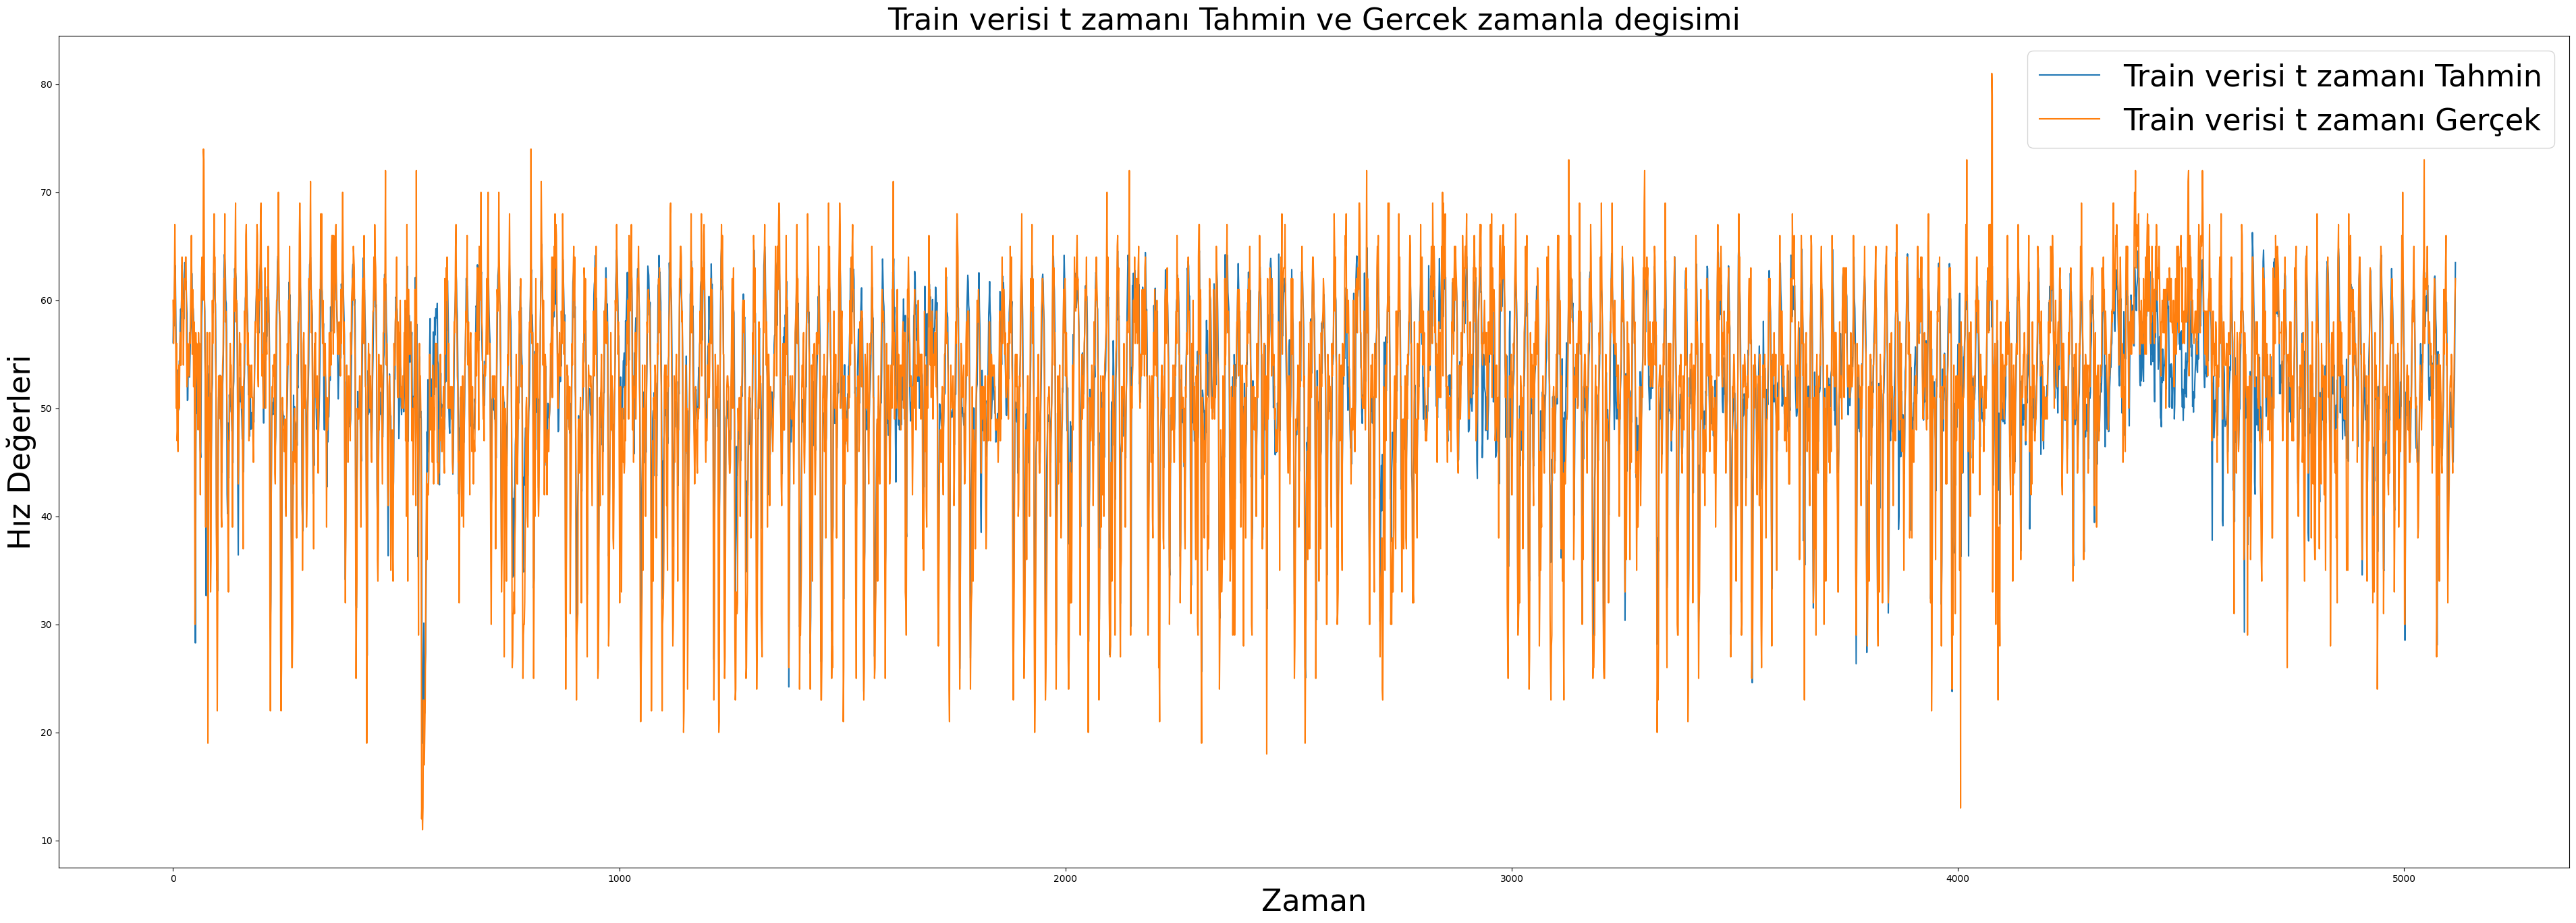

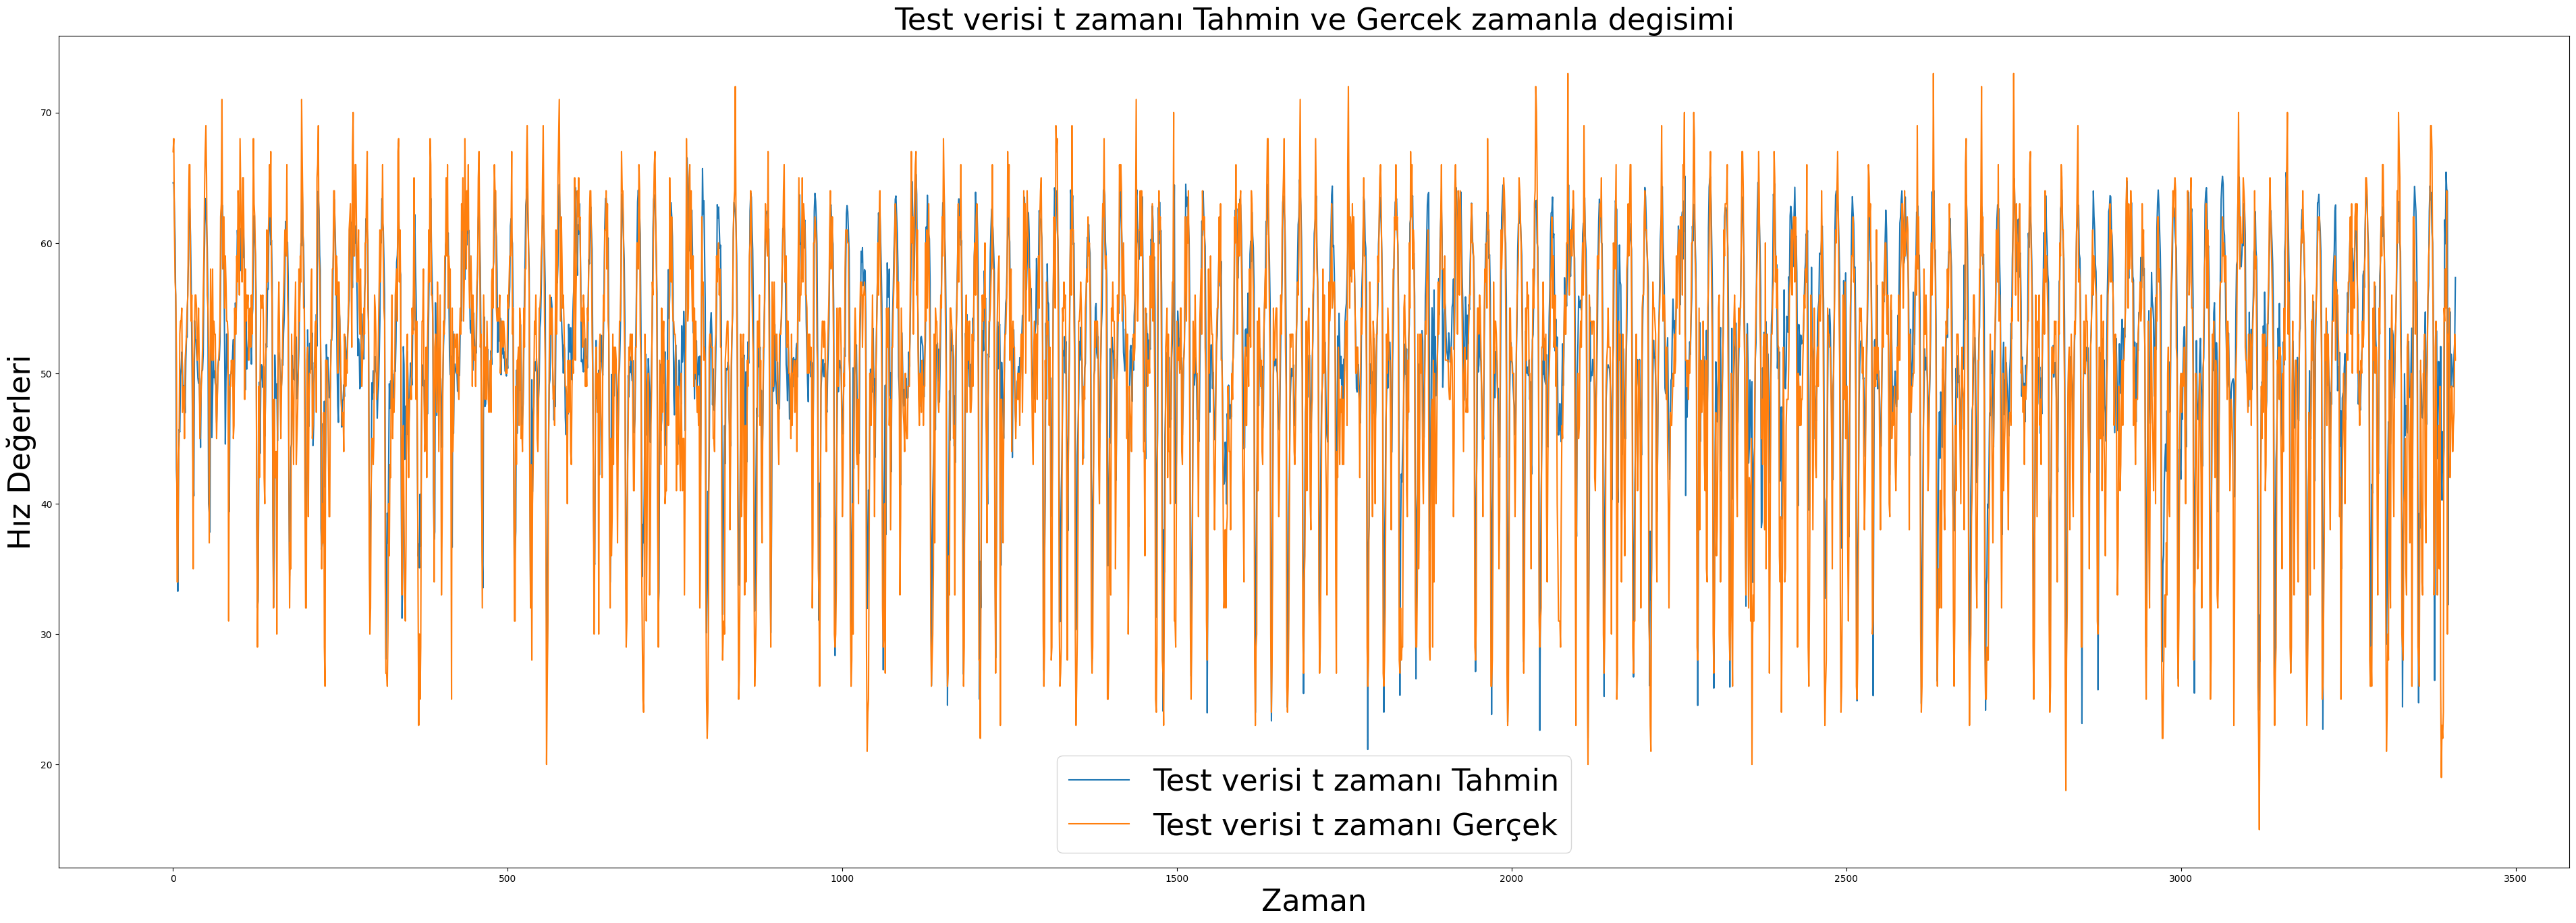

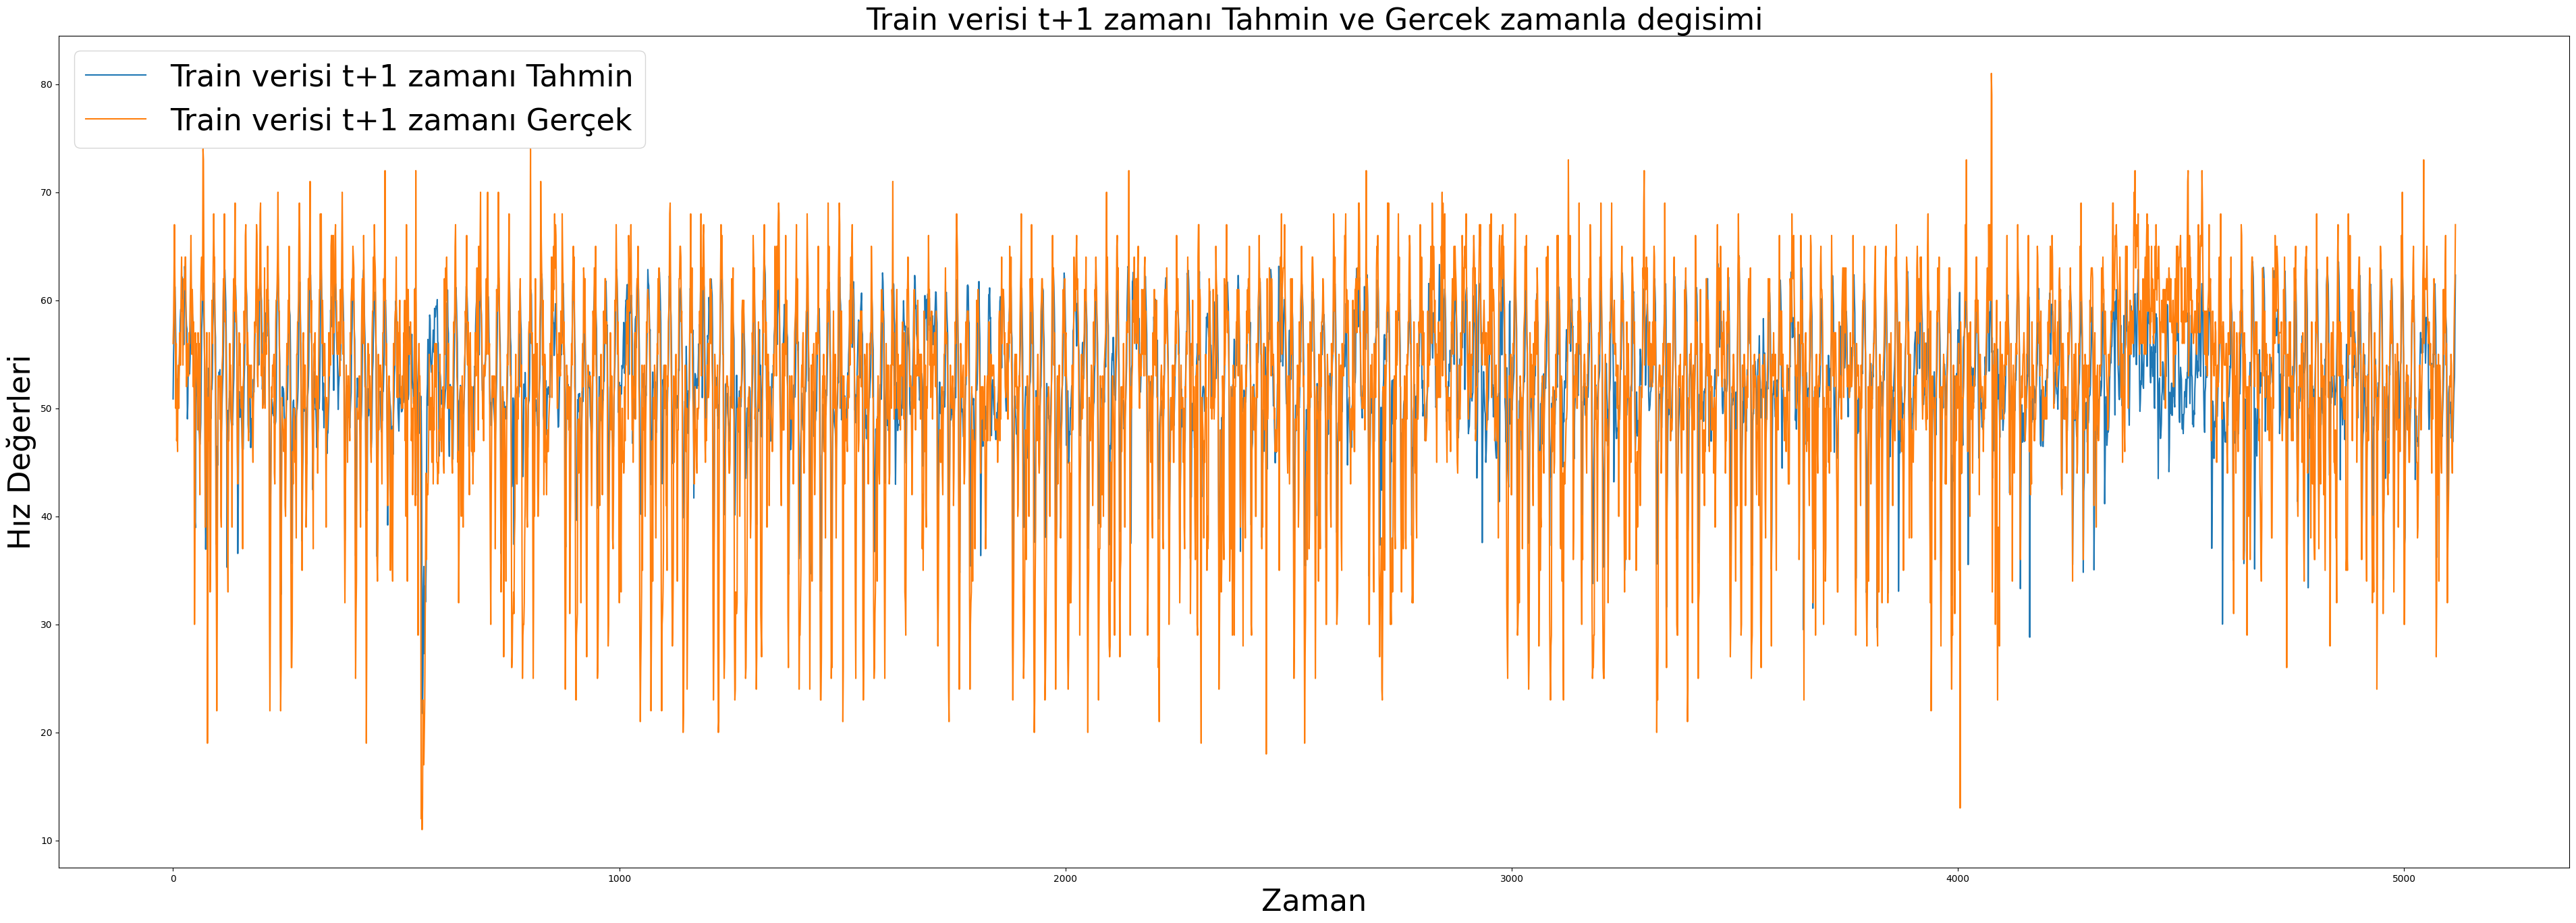

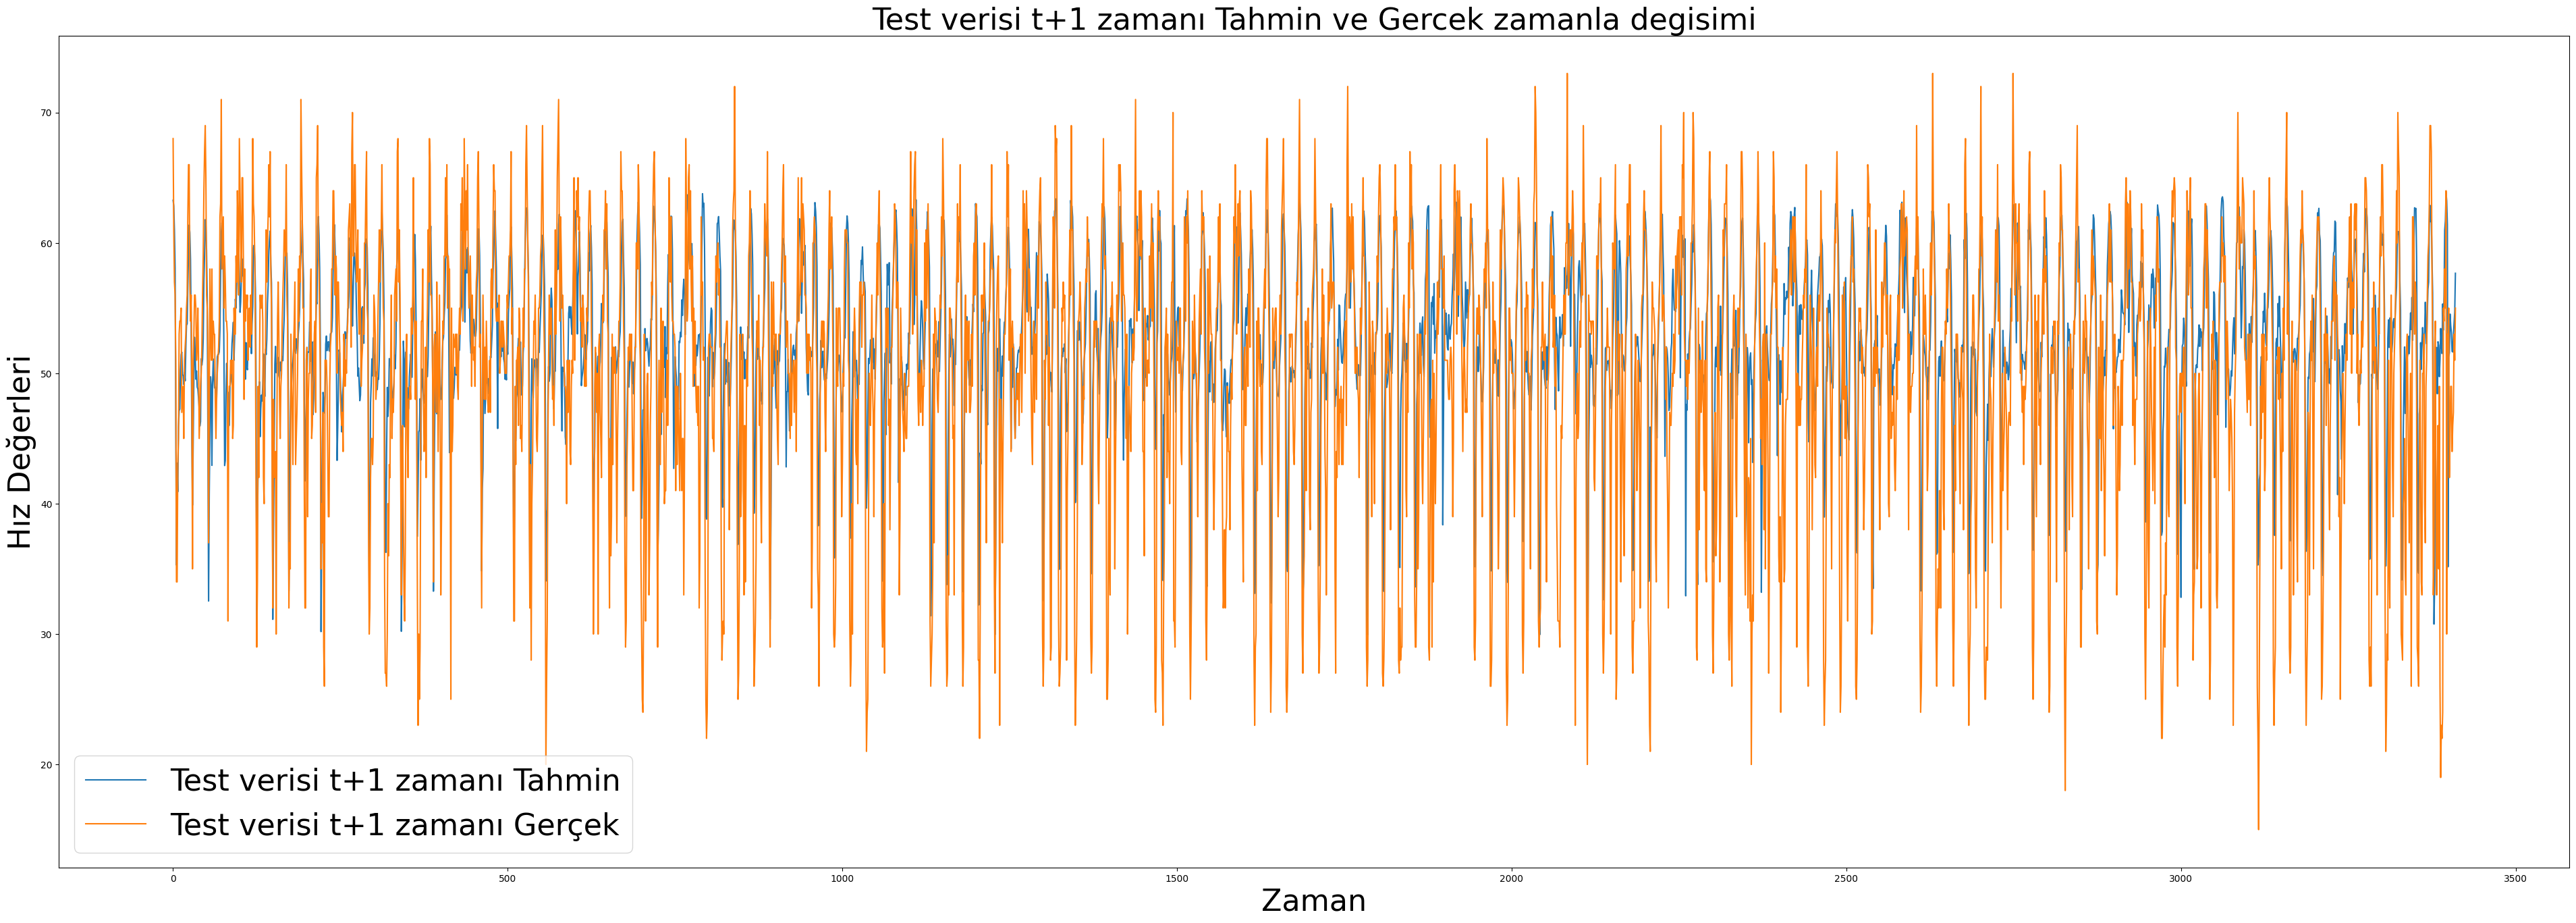

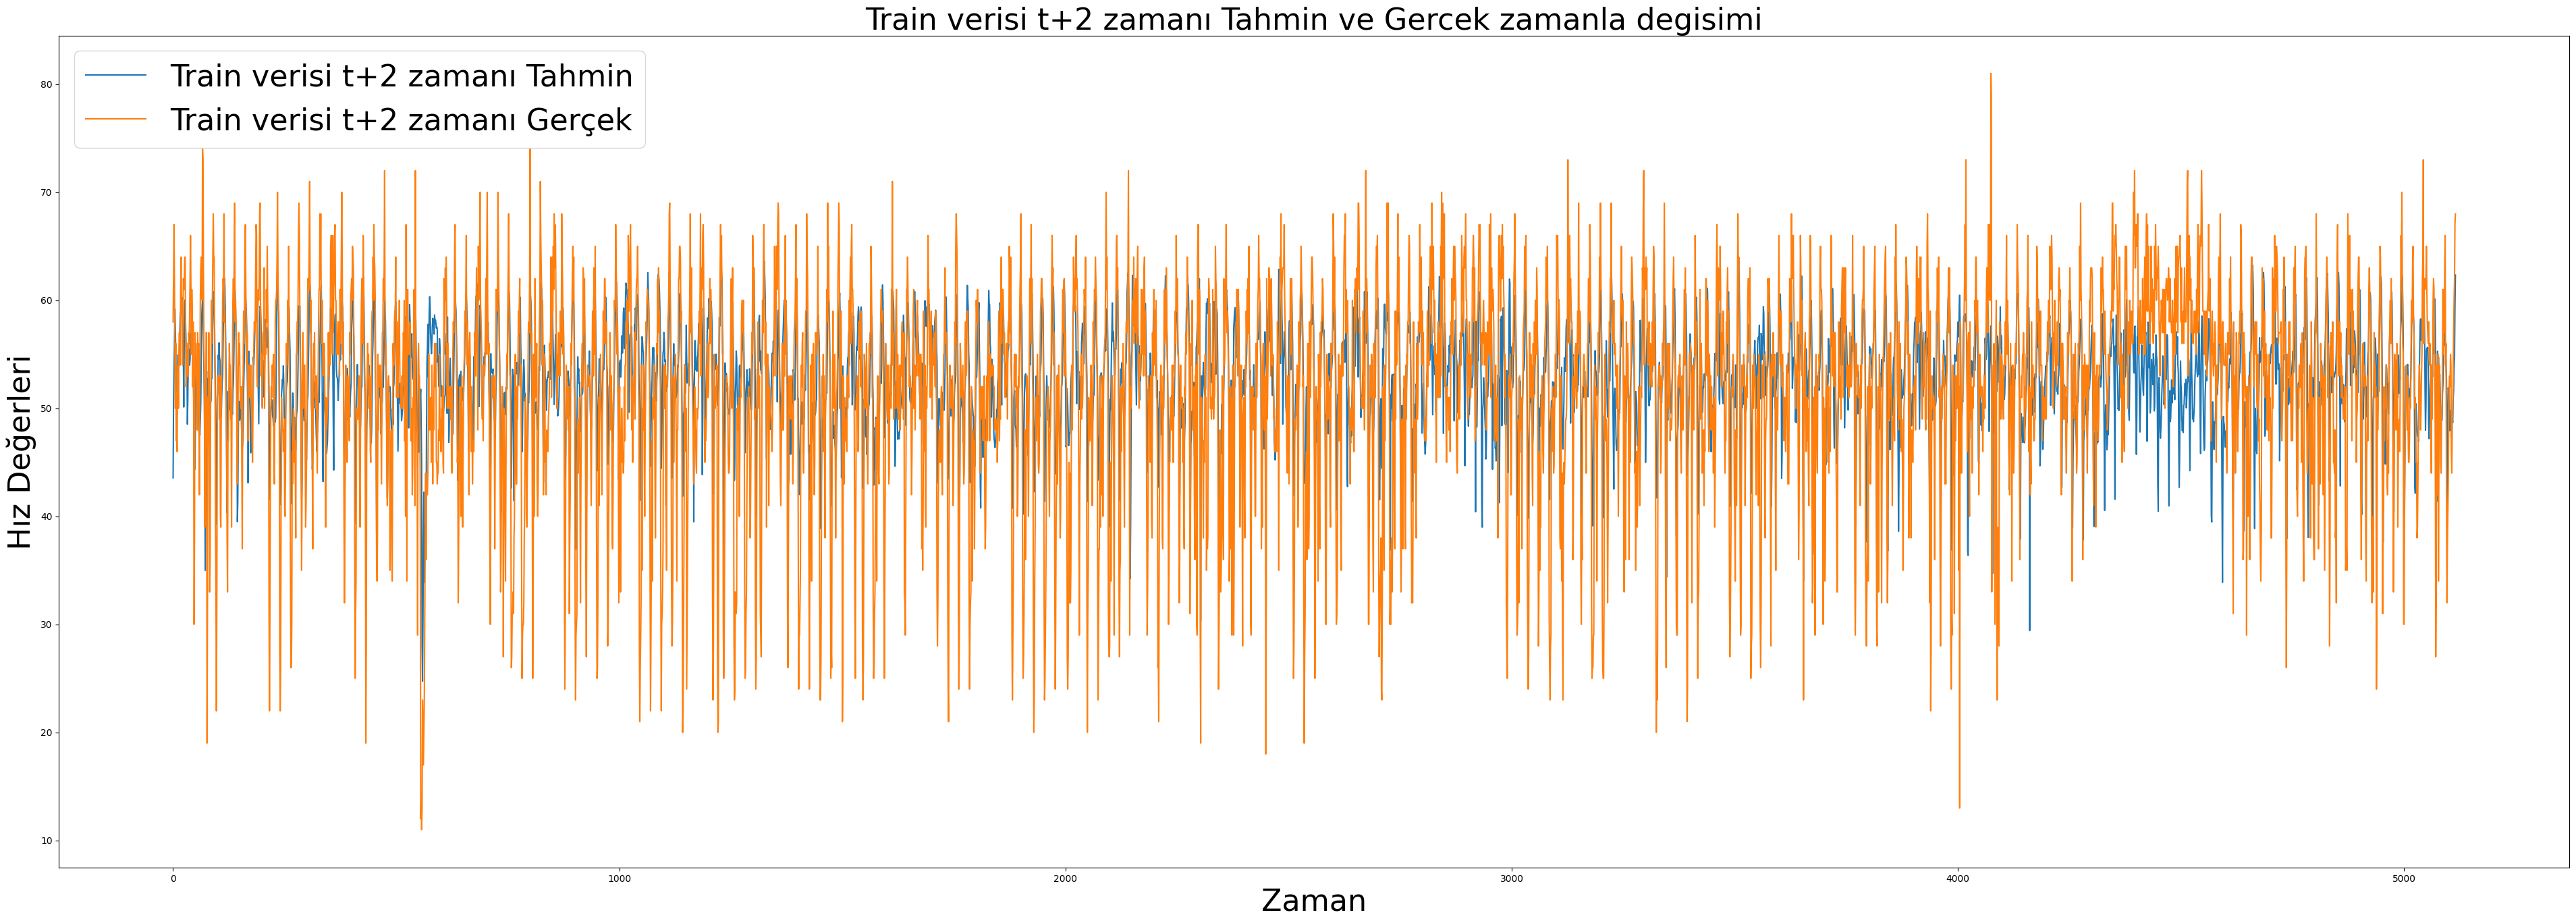

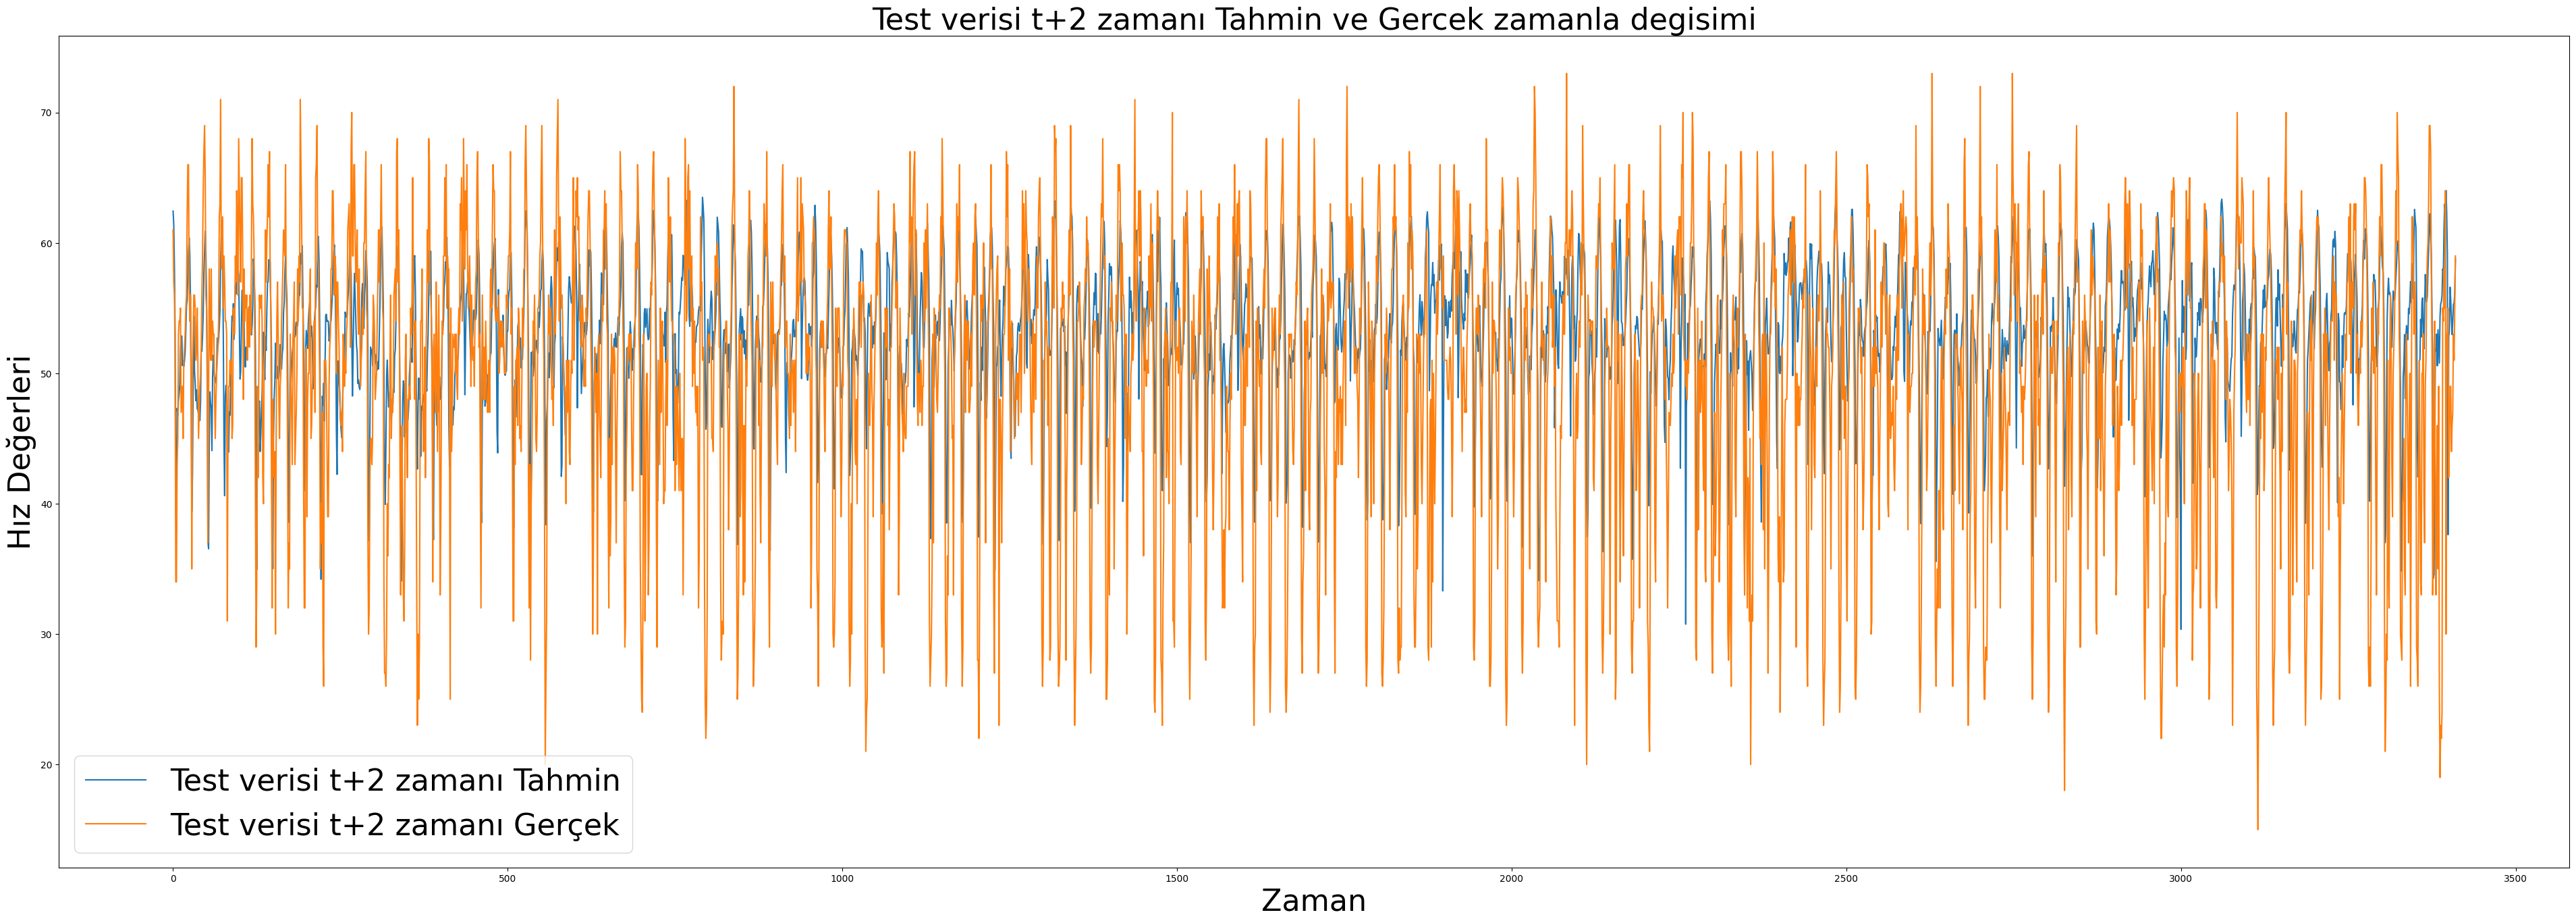

In [19]:
train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter1.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter2.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter3.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter4.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter5.png')

test_y3=test_y[:,2]
pred_test_y3=pred_test_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y3, label = "Test verisi t+2 zamanı Tahmin")
plt.plot(test_y3, label = "Test verisi t+2 zamanı Gerçek")
plt.title('Test verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter6.png')